In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
from datetime import datetime, timedelta

In [2]:
df = pd.read_csv("./csv_202203_202309/chicago_bike_202203_202309.csv")
df = df.dropna()
df.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,241C440C74CB31BB,classic_bike,2022-08-05 16:13:36,2022-08-05 16:22:40,DuSable Museum,KA1503000075,Cottage Grove Ave & 51st St,TA1309000067,41.791568,-87.607852,41.803038,-87.606615,casual
1,53A7590B28ED25E2,classic_bike,2022-08-11 23:30:11,2022-08-11 23:30:56,California Ave & Milwaukee Ave,13084,California Ave & Milwaukee Ave,13084,41.922695,-87.697153,41.922695,-87.697153,casual
2,C34EE790A58C0434,classic_bike,2022-08-21 14:09:08,2022-08-21 15:10:46,California Ave & Division St,13256,California Ave & Division St,13256,41.903029,-87.697474,41.903029,-87.697474,casual
3,49259B4BA064D81B,electric_bike,2022-08-21 16:15:12,2022-08-21 16:29:30,Wood St & Chicago Ave,637,Wood St & Chicago Ave,637,41.895673,-87.672075,41.895634,-87.672069,casual
4,BEE91D557E47FE83,classic_bike,2022-08-21 02:11:26,2022-08-21 03:44:04,California Ave & Milwaukee Ave,13084,California Ave & Milwaukee Ave,13084,41.922695,-87.697153,41.922695,-87.697153,casual


In [13]:
# 1000件サンプリングする
sample = df.sample(n=1000, random_state=0)
sample.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
3768399,DC65867E66208AF5,electric_bike,2023-06-22 09:04:33,2023-06-22 09:07:20,Jefferson St & Monroe St,WL-011,Franklin St & Monroe St,TA1309000007,41.880364,-87.642653,41.880317,-87.635185,casual
233945,85B7B9E837C5DCE5,classic_bike,2022-08-17 06:47:22,2022-08-17 06:52:15,Southport Ave & Wellington Ave,TA1307000006,Southport Ave & Roscoe St,13071,41.935733,-87.663576,41.943739,-87.664020,casual
3366502,9E710060FFDA29C4,classic_bike,2023-08-27 15:17:04,2023-08-27 15:23:17,Sheffield Ave & Wrightwood Ave,TA1309000023,DuSable Lake Shore Dr & Diversey Pkwy,TA1309000039,41.928712,-87.653833,41.932588,-87.636427,casual
7538323,D6C7C2DDC5ED2F14,classic_bike,2023-01-17 13:15:37,2023-01-17 13:21:11,Halsted St & 63rd St,KA1503000055,Racine Ave & 61st St,562,41.779381,-87.644621,41.783189,-87.654372,casual
960848,98C3242566E0AC2E,docked_bike,2022-05-29 14:49:34,2022-05-29 15:25:40,DuSable Lake Shore Dr & Belmont Ave,TA1309000049,Streeter Dr & Grand Ave,13022,41.940775,-87.639192,41.892278,-87.612043,casual


In [4]:
def return_nm(df):
    df['started_at'] = pd.to_datetime(df['started_at'])
    df['ended_at'] = pd.to_datetime(df['ended_at'])
    # started_atで昇順にソート
    df = df.sort_values(by='started_at')
    current_timestamp = df['started_at'].min()
    end_timestamp = df["started_at"].max()
    interval = timedelta(days=1)

    node_list = []
    edge_list = []
    timestamp = []

    while current_timestamp <= end_timestamp:
        timestamp.append(current_timestamp)
        next_timestamp = current_timestamp + interval
        df_tmp = df[(df['started_at'] >= current_timestamp) & (df['started_at'] < next_timestamp)]

        # node_listにはユニークなstart_station_idを追加
        node_list.append(len(df_tmp['start_station_id'].unique()))

        # edge_listにはdf_tmpの行数を追加
        edge_list.append(len(df_tmp))

        current_timestamp = next_timestamp

    return node_list, edge_list, timestamp

In [34]:
node_list, edge_list, timestamp = return_nm(df)

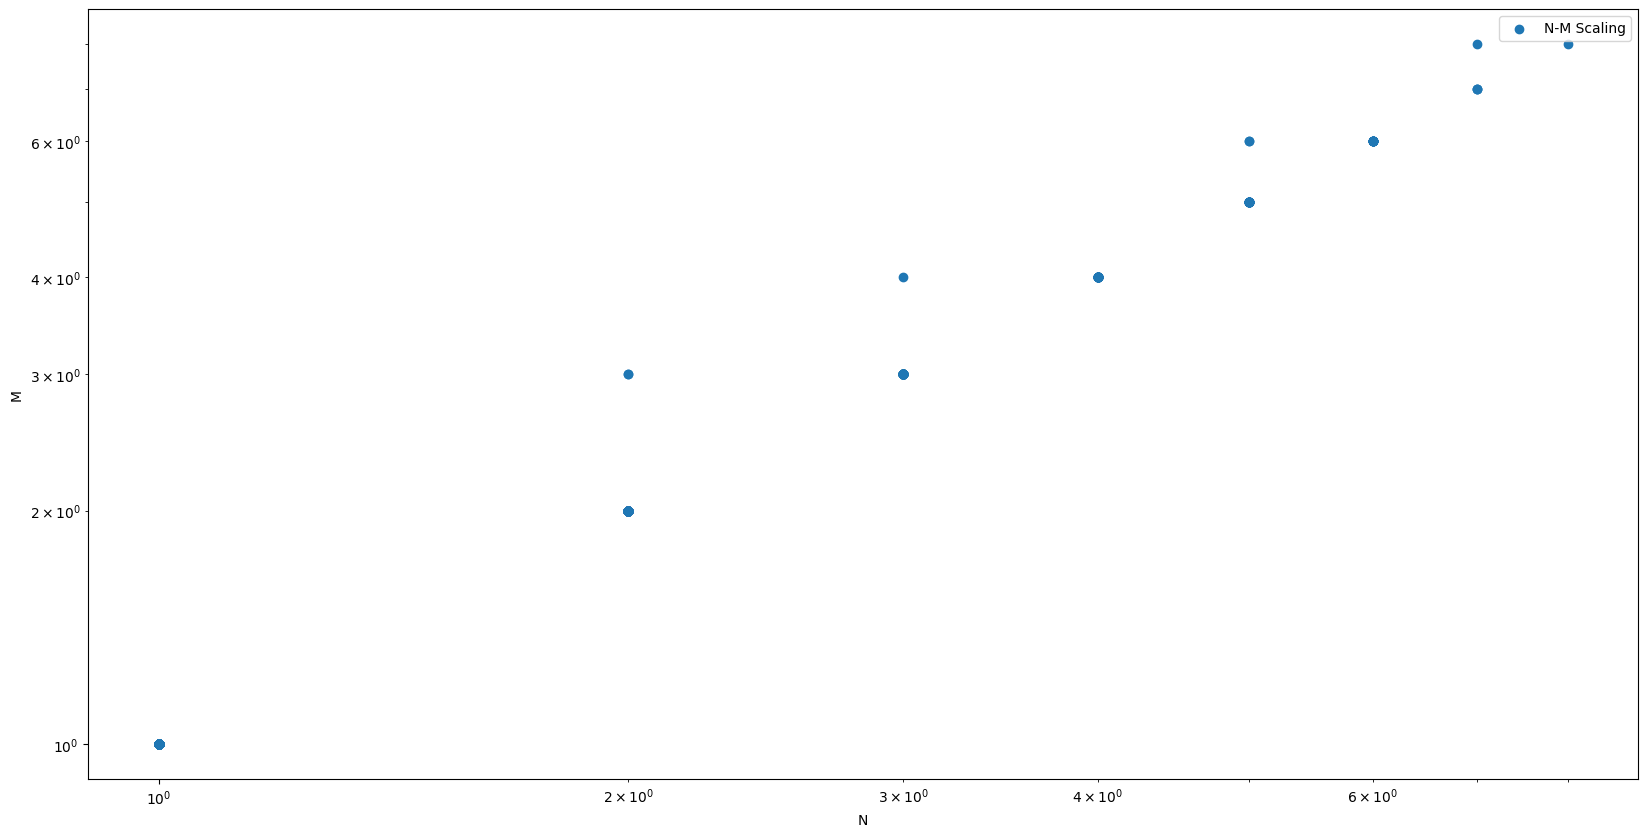

In [15]:
# node_listとedge_listをグラフにプロット
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)
ax.scatter(node_list, edge_list, label='N-M Scaling')
ax.set_xlabel('N')
ax.set_ylabel('M')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()
plt.show()


In [16]:
# model1を使って、kappaを推定する
def model1(x, kappa):
    a = (1+np.sqrt(1+(32*x/kappa)))/2
    return a*(1-2/a*kappa*(1-(1-kappa/2)**a))

In [50]:
popt, pcov = curve_fit(model1,node_list,edge_list,p0=[1])
kappa = popt[0]
print("kappa:", kappa)

kappa: 2.671594175788461e-05


/var/folders/t8/gtqjgg0n60jdkgk801tvsrx40000gn/T/ipykernel_11798/1945244423.py:3: RuntimeWarning: invalid value encountered in sqrt
  a = (1+np.sqrt(1+(32*x/kappa)))/2


In [51]:
Np = []
for i in range(len(edge_list)):
    Np.append(1+np.sqrt(1+32*edge_list[i]/kappa)/2)

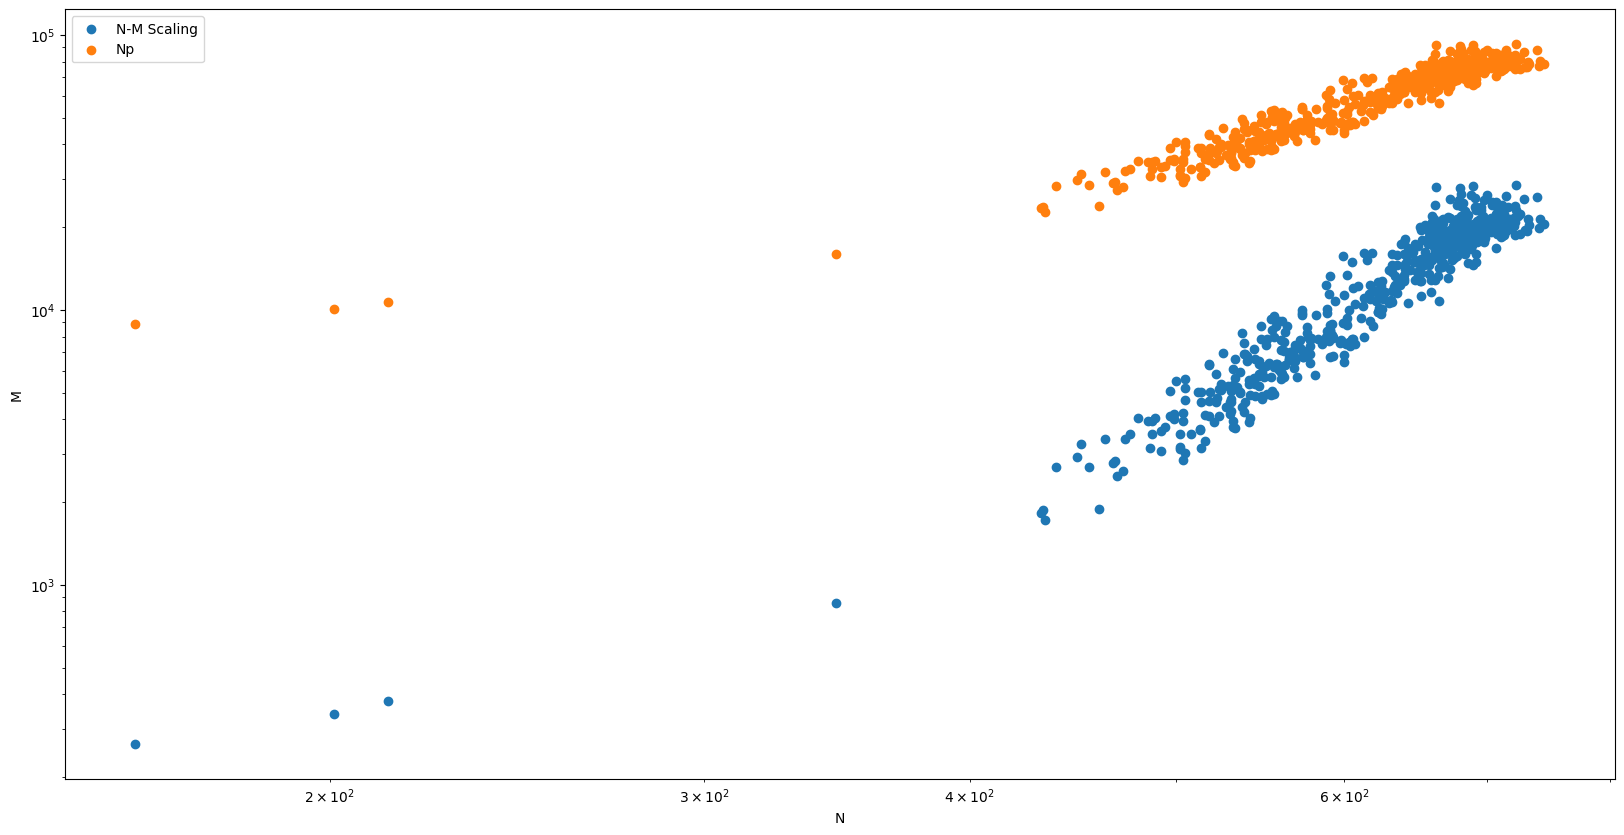

In [52]:
# node_listとedge_listをグラフにプロット
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)
ax.scatter(node_list, edge_list, label='N-M Scaling')
ax.scatter(node_list, Np, label='Np')
ax.set_xlabel('N')
ax.set_ylabel('M')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()
plt.show()


In [27]:
def model1_Np(m, *params):
    kappa = 1.0876
    return 1+np.sqrt(1+32*edge_list/kappa)/2

In [21]:
param_init = 1.0
sample_x = np.arange(1, 1000, 10)

In [28]:
# フィッティングを行うための関数
def fit(func, X, Y, param_init):
    """
    func:データxに近似したい任意の関数
    x:データ
    param_init:パラメータの初期値
    popｔ:最適化されたパラメータ
    pocv:パラメータの共分散
    """
    popt,pocv=curve_fit(func, X, Y, p0=param_init)
    perr = np.sqrt(np.diag(pocv)) #対角成分が各パラメータの標準誤差に相当
    y=func(sample_x, *popt)
    return y, popt, perr

In [29]:
result = fit(model1_Np, edge_list, param_init=param_init)
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.scatter(node_list, edge_list, label='N-M Scaling')
ax.plot(sample_x, result[0])

TypeError: fit() missing 1 required positional argument: 'Y'